# AIAIART #8 - Neural Cellular Automata

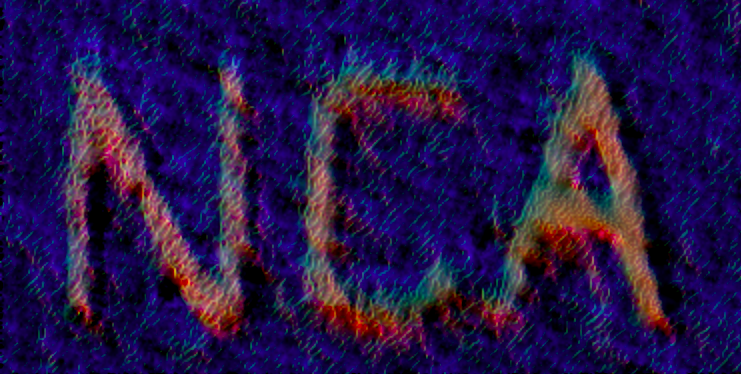

Today we're diving into one of my favourite topics: Neural Cellular Automata. Buckle up for some fun with differentiable self-organising systems!

Before we get into the notebook though, I should acknowledge that this work builds on the shoulders of giants, and specifically on the amazing work done by Alexander Mordvintsev (https://twitter.com/zzznah) along with co-authors Ettore Randazzo, Eyvind Niklasson, Michael Levin who pioneered [a lot of this stuff](https://distill.pub/2020/selforg/). In fact, maybe let's begin by checking out one of their fantastic articles: https://distill.pub/2020/growing-ca/. 

(NB: This is required reading. Seriously - don't carry on with this lesson until you've opened that link!)

In [ ]:
#@title Lesson Video
import IPython.display as ipd
html = ipd.display(ipd.HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/X2-ucB74oEk" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>'))
html

## Setup

In [ ]:
!pip install -q open_clip_torch fastcore

In [ ]:
#@title imports and utility functions

import torch
import torchvision.transforms as T
from torch import nn
import torch.nn.functional as F
from PIL import Image
from matplotlib import cm
from matplotlib import pyplot as plt
from IPython.display import display, clear_output, HTML
from base64 import b64encode
from tqdm.notebook import tqdm
import numpy as np

# *** Utility Functions ***

def show_grid(maxn=20, w=3, h=3):
  """ Assuming images have been saved in steps/ and there are 
  at least maxn of them with the naming convention 0001.jpeg.
  This function loads w x h images and shows them in a grid.
  Useful for a quick preview to see if anything interesting is 
  happening"""
  fig, axs = plt.subplots(h, w)
  plt.tight_layout()
  for x in range(h):
    for y in range(w):
      i = int(maxn * (x*w+y)/(w*h))
      axs[x][y].imshow(Image.open(f'steps/{i:05}.jpeg'))

def render(ca, n=100, w=256, h=256, save_every=1, exp_frac=0, display_grid=True):
  """ Render n steps of a ca starting from a random grid.
  Saves an image every save_every steps into the steps/ folder.
  Smooths the aniation with exponential averaging set by exp_frac
  """
  !rm -r steps
  !mkdir steps
  grid = torch.rand(1, 1, w, h) # bs, channels, w, h
  im_array = np.array(grid[0][0].clip(0, 1))
  for i in tqdm(range(n)):
    grid = ca(grid)
    im_array = exp_frac*im_array + (1-exp_frac)*np.array(grid[0][0].clip(0, 1))
    im = Image.fromarray(np.uint8(cm.gist_earth(im_array)*255)).convert('RGB')
    if i % save_every == 0:
      im.save(f'steps/{i//save_every:05}.jpeg')
  if display_grid:
    show_grid(maxn=30, w=3, h=2)

def progress_video():
  # Turn the images in steps/ into a video with ffmpeg
  !ffmpeg -y -v 0 -framerate 24 -i steps/%05d.jpeg video.mp4

  # Display it inline
  mp4 = open('video.mp4','rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  return HTML("""
  <video width=256 controls>
        <source src="%s" type="video/mp4">
  </video>
  """ % data_url)



In [ ]:
# Setting device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Introduction to CA

![cgol gif](https://res.cloudinary.com/practicaldev/image/fetch/s--RAcUUeRg--/c_limit%2Cf_auto%2Cfl_progressive%2Cq_66%2Cw_880/https://github.com/alinp25/alinp25.github.io/raw/master/assets/images/gameoflife/gli.gif)

Cellular automata have a long history in computing. Perhaps you cut your teeth programming Conway's Game of Life and watching the pretty patterns, or read 'A New Kind of Science' by Stephen Wolfram and decided that we're all just a sequence in the swirls of Rule 34. But if you haven't stumbled across this delightful little idea, here's a quick recap:

We set up a system of 'cells', often represented by pixels in a line or a grid. Each cell can 'see' their immediate neighbors, and can change it's output based on this information. 

As an example, here are some situations from a famous cellular automata, the aforementioned Game of Life:

![CGOL rules demo](https://www.researchgate.net/profile/Guy-Engelen/publication/268437334/figure/fig1/AS:669550194483202@1536644614124/Some-transition-rules-for-the-Game-of-Life.jpg)

You can explore live demos of this system online at places like [this website](https://playgameoflife.com/) or see some of the [crazy things people have done with it on YouTube](https://www.youtube.com/watch?v=Kk2MH9O4pXY). In this case, the cell can have only two states, alive and dead. But we can also have more comlicated 'worlds' (hexagons, 3d space, graphs...) and more nuanced rules that produce one or more continuous outputs.

There are MANY YouTube videos out there on cellular automata. I particularly enjoyed [this 30-minute video](https://www.youtube.com/watch?v=coL5GKxYg90) from an artist who has been working for years with different types of cellular automata, and has found some really interesting ways of exploring the space of possible CAs - that might be a good place to start if you're interested in these things and want more inspiration.

## Convolutional CA

![microorganism gif](https://media0.giphy.com/media/TQmVlE6Kmg69q/giphy.gif)

I came across a [great video](https://www.youtube.com/watch?v=3H79ZcBuw4M) on 'neural cellular automata' by the person behind [neuralpatterns.io](https://neuralpatterns.io/) - in it he showcases some fun emergent behaviour from a type of continuous cellular automata. This was the inspiration for this whole project, and I think the type of continuous cellular automata shown are a good stepping stone towards the more complex neural CA we'll explore later in this lesson.

We'll need a few things to do this kind of simulation.
- A grid to which our update rules will be applied
- One or more kernels that we can convolve with our image
- An activation function through which the result of the convolution will be passed
- Some code for viewing results etc

Here's one way we could achieve these minimum requirements in PyTorch:

In [ ]:
# Create our grid (32x32 for this demo)
grid = torch.randn(1, 1, 32, 32) # batch_size, channels, w, h

# Create a random kernel
kernel = torch.randn(1, 1, 3, 3) # batch_size, channels, kernel_size, kernel_size

# Define an activation function
act = torch.tanh

# Compute the output after one step:
output = act(F.conv2d(grid, kernel, padding='same')) # Think: What happens to the sizes if we remove padding?

# Visualize the various arrays:
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
axs[0].imshow(grid[0][0])
axs[0].set_title('Starting grid')
axs[1].imshow(kernel[0][0])
axs[1].set_title('Kernel')
axs[2].imshow(output[0][0])
axs[2].set_title('Grid after one update step')
plt.show()

We can create our own pytorch module to do wrap the ideas above by inheriting from nn.Module. This gives us some extra superpowers down the road, and makes our code nice and neat. Here's how this might look:

In [ ]:
class ConvCA(nn.Module):
  """Applies a convolutional kernel over an image and passes the result through
  an activation function."""
  def __init__(self, kernel_size=3, kernel_scale=0.5, act=torch.tanh):
    """Sets up the kernel and activation function.
     Defaults to:
    - kernel_size=3, 
    - kernel_scale=0.5, # sometimes it's nice to scale down the kernel
    - act=torch.tanh
    """
    super().__init__()
    self.kernel = torch.randn(1, 1, kernel_size, kernel_size)*kernel_scale
    self.act = act
    
  def forward(self, x):
    """Applies the kernel and activation function to a grid, x"""
    return self.act(F.conv2d(x, self.kernel, padding=1))

And seeing it in action:

In [ ]:
# Creating a ConvCA
ca = ConvCA()

# Applying the ca to the grid from before is now as easy as:
output = ca(grid)

print(grid.shape, output.shape) # Shape is maintained thanks to the padding.

I wrote some helper code to quickly apply one of these CAs repeatedly, saving images to a 'steps/' directory and giving a preview at the end so we can quickly see if anything interesting is happening. 

Run the following cell a few times - each time will create a ConvCA with a random kernel and run it for 100 steps on a random grid. If you're curious to see the code, check the 'Imports and Utility Functions' cell for the definition of `render`.

In [ ]:
ca = ConvCA(kernel_scale=0.5)
render(ca)

In [ ]:
# Show a video based on the images in the steps folder
progress_video()

Some can be flickery and uninteresting at first glance, but if we speed them up (only saving every 5th frame for eg) and smooth some of the flicker by averaging over past frames (using the exp_frac parameter) then they might become more interesting:

In [ ]:
render(ca, n=1000, save_every=5, exp_frac=0.8, display_grid=False)
progress_video()

#### Making worms

In the aforementioned video there is a really cool pattern shown that I wanted to re-create. 

It needs a specific activation function so lets define that and check that it matches the one shown:

In [ ]:
def inverse_gaussian(x):
    return -1./torch.pow(2., (0.6*torch.pow(x, 2.)))+1.;

# Plot:
x = torch.linspace(-4, 4, 30)
plt.plot(x, inverse_gaussian(x))

And combining this with a very specific kernel:

In [ ]:
worm_ca = ConvCA(act=inverse_gaussian) # Using the above function as the activation function
worm_ca.kernel = torch.tensor([[[[0.68, -0.9, 0.68],
                                [-0.9, -0.66, -0.9],
                                [0.68, -0.9, 0.68]]]])
render(worm_ca, n=8000, save_every=10, exp_frac=0.9, display_grid=False)
progress_video()                             

In [ ]:
# Exercise: play around with different activation functions
# and random kernels. You can look at or modify ca.kernel to 
# change or save ones you like. For example, here's one I found:
ca = ConvCA(act=inverse_gaussian)
ca.kernel = torch.tensor([[[[ 1.8662,  0.6414, -0.1999],
          [-0.1236, -0.1972,  1.0723],
          [ 0.6696, -0.4720, -0.1853]]]])
render(ca, n=500, save_every=1, exp_frac=0.9, display_grid=False)
progress_video()

You'll notice weird behaviour around the endges. F.conv2d padding pads the grid with 0s. We need the padding so we keep the shape step-to-step, but this means cells on the edges get strange stuff happening. With nn.Conv2d you can specify pad mode to be 'circular', which means that kernels wrap around the edges. 

Another thing about these initial tests: all the updates get applied at the same time. This implies a sort of 'global clock' which isn't necessarily something that fits with our biological cells analogy. 

It's amazing how much we can get out of these very simple systems, but I'm sure you're beginning to think of ways to extend them. What if we have multiple filters, maybe combined by a set of learned weights? What about multi-channel images? And how do we make them 'learn' things and make self-healing lizards?

## Neural CA

![monty python gif](https://img.gifglobe.com/grabs/montypython/MontyPythonAndTheHolyGrail/gif/UTkn6Q3degNm.gif)

We want to create cellular automata that can self-organise into interesting patterns. To get there, we'll improve on the convolutional CA from the previous section by:

- Adding some learnable parameters that decide what to do
- Switching to nn.Conv2d for circular padding
- Applying randomized updates (biologically inspired) rather than using some sort of global clock
- Introducing additional 'non output' channels that can be used for information passing. Again, biologically inspired by chemical signalling.
- Including an option to hard-code the kernels/filters used, to reduce trainable parameters and to start with some that mimic biological sensing ideas, such as the sobel filters which highlight gradients.

Credit where it is due: much of the code in this section pulls inspiration or is stolen verbatim from [$\mu$NCA: Texture Generation with Ultra-Compact Neural Cellular Automata](https://arxiv.org/abs/2111.13545) by Alexander Mordvintsev & Eyvind Niklasson.


For our first trick, here's a class that defines a simple NCA which works on a 4-channel grid, uses some hard-coded filters and contains a simple NN brain with `hidden_n` hidden neurons. 

We're starting with this particular case for a few reasons. For one thing, this is a bit of a 'MVP' that we can use as a template for future versions. But I've also chosen these particular parameters for another reason, which we'll get to once we've trained one ;)

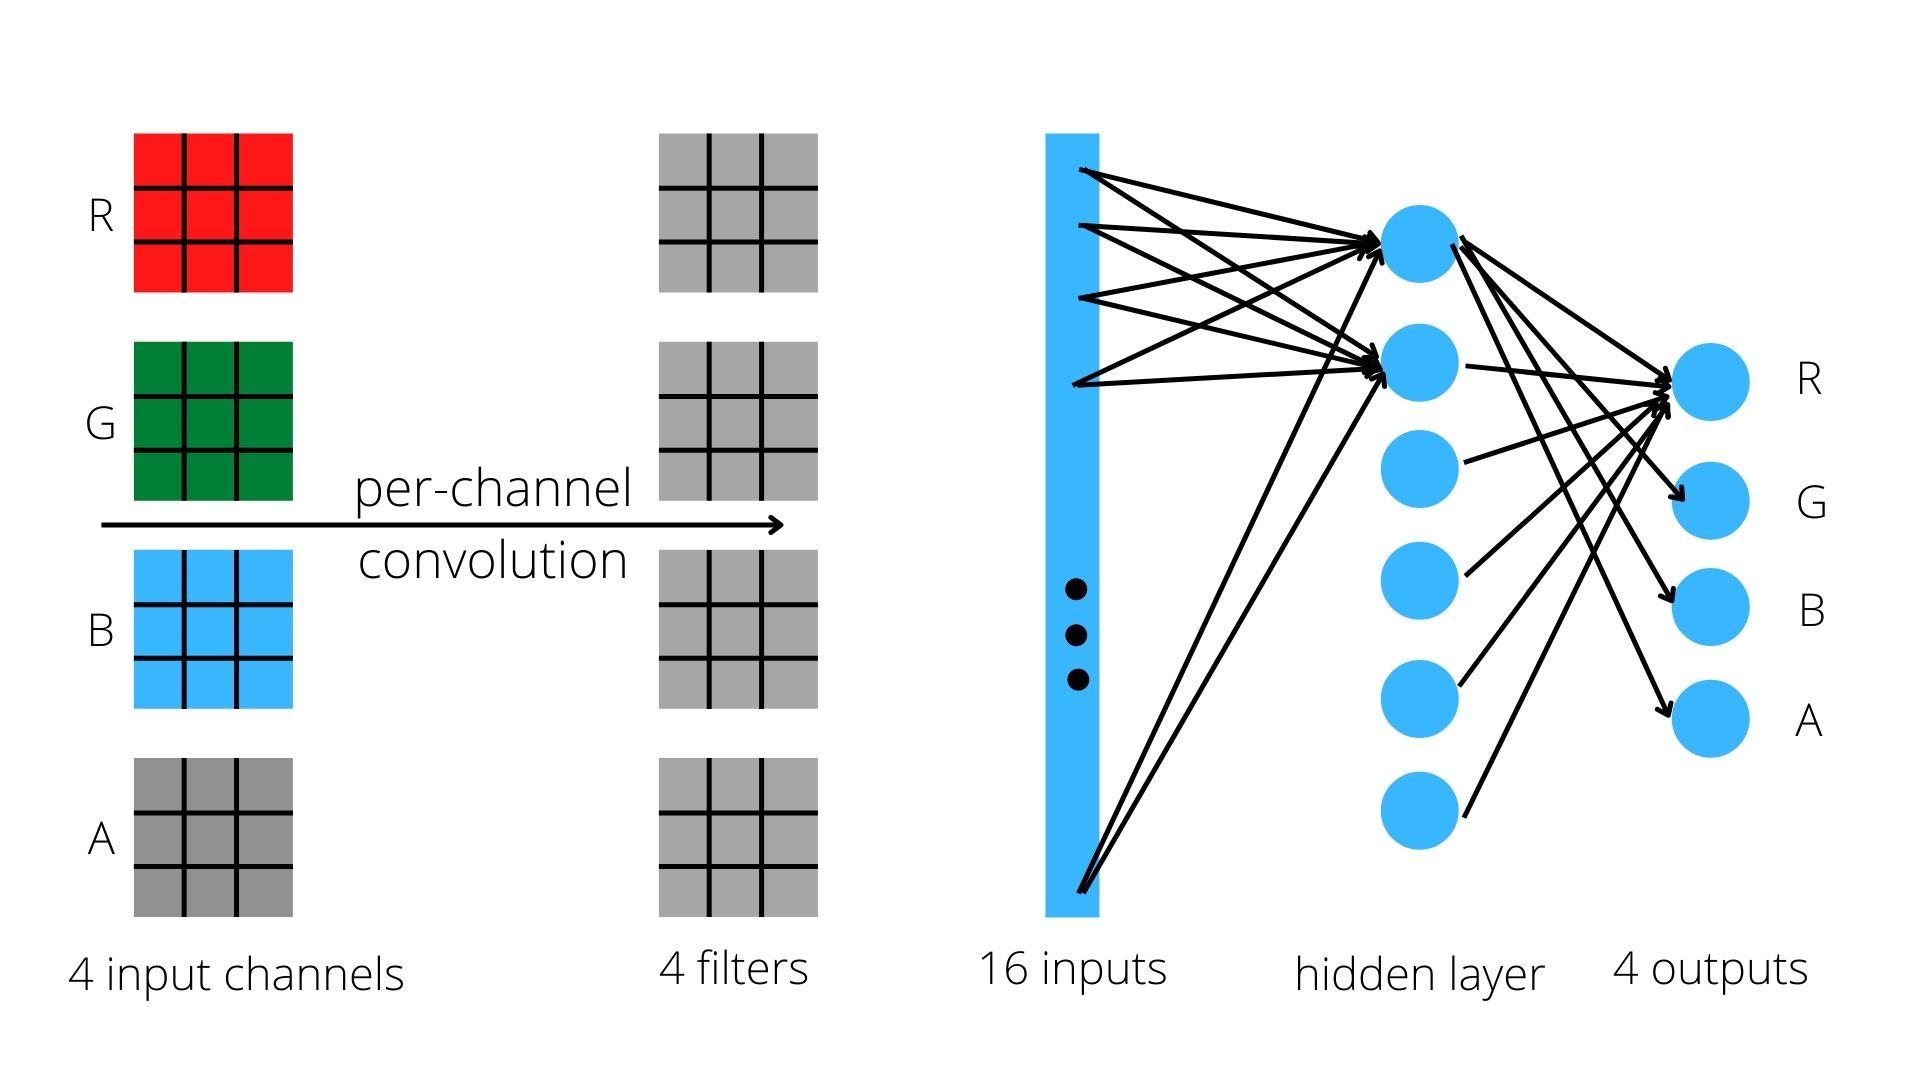

In [ ]:
#@markdown ##### SimpleCA Class definition
class SimpleCA(nn.Module):
  def __init__(self, hidden_n=6, zero_w2=True, device=device):
    super().__init__()
    # The hard-coded filters:
    self.filters = torch.stack([torch.tensor([[0.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,0.0]]),
          torch.tensor([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]]),
          torch.tensor([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]]).T,
          torch.tensor([[1.0,2.0,1.0],[2.0,-12,2.0],[1.0,2.0,1.0]])]).to(device)
    self.chn = 4

    # Our little 'brain'. 
    # Discuss: how is convolution with a 1x1 filter basically 
    # the same as defining an MLP with linear layers?
    self.w1 = nn.Conv2d(4*4, hidden_n, 1).to(device)
    self.relu = nn.ReLU()
    self.w2 = nn.Conv2d(hidden_n, 4, 1, bias=False).to(device)

    # It's useful to be able to start with small or 0 weights in 
    # the second layer, but you can experiment with skipping this
    # by setting zero_w2=False.
    if zero_w2:
      self.w2.weight.data.zero_()
    
    # Keep track of which device we're using
    self.device = device

  def perchannel_conv(self, x, filters):
    '''filters: [filter_n, h, w]'''
    b, ch, h, w = x.shape
    y = x.reshape(b*ch, 1, h, w)
    y = torch.nn.functional.pad(y, [1, 1, 1, 1], 'circular')
    y = torch.nn.functional.conv2d(y, filters[:,None])
    return y.reshape(b, -1, h, w)
    
  def forward(self, x, update_rate=0.5):
    y = self.perchannel_conv(x, self.filters) # Apply the filters
    y = self.w2(self.relu(self.w1(y))) # pass the result through out 'brain'
    b, c, h, w = y.shape

    # The update mask means that only some pixels are updated:
    update_mask = (torch.rand(b, 1, h, w).to(self.device)+update_rate).floor()

    # Note that the model output (y) is added to x where update_mask is 1:
    return x+y*update_mask
  
  def to_rgb(self, x):
    # TODO: rename this to_rgb & explain
    return x[...,:3,:,:]+0.5

  def make_video(self, x, n_steps=100):
    !mkdir -p steps
    !rm steps/*
    for i in range(n_steps):
      with torch.no_grad():
        x = ca(x)
        img = ca.to_rgb(x).detach().cpu().clip(0, 1).squeeze().permute(1, 2, 0)
        img = Image.fromarray(np.array(img*255).astype(np.uint8))
        img.save(f'steps/{i:05}.jpeg')
    return progress_video()

  def seed(self, n, sz=128):
    """Initializes n 'grids', size sz. In this case all 0s."""
    return torch.zeros(n, self.chn, sz, sz).to(self.device)

  def print_weights(self):
    """A mystery tool that will be useful later ;) """
    ws, bias = [p for p in self.w1.parameters()]
    nh = ws.shape[0]
    print(f'const int nh = {nh};')
    print(f'float b1[{len(bias)}] = float[{len(bias)}]({",".join([str(float(s)) for s in list(bias)])[:-1]});')
    nh = ws.shape[0]
    s = f'float w1[{nh*16}] = float[{nh*16}]('
    for p in ws.squeeze().flatten():
      p = str(float(p))
      s += p
      if not '.' in p:
        s += '.'
      s += ','
    s = s[:-1]+');'
    print(s)
    ws= [p for p in self.w2.parameters()][0]
    s = f'float w2[{nh*4}] = float[{nh*4}]('
    for p in ws.squeeze().flatten(): 
      p = str(float(p))
      s += p
      if not '.' in p:
        s += '.'
      s += ','
    s = s[:-1]+');'
    print(s)

In [ ]:
ca = SimpleCA(hidden_n=8,zero_w2=False)
[p.shape for p in ca.parameters()] # The learnable parameters

In [ ]:
# At the moment it's initialized with random weights:
grid = ca.seed(1)
ca.make_video(grid)

## Training Neural CA

![puppy training gif](https://c.tenor.com/4M1WA_iJmYMAAAAM/fail-dog.gif)

We'll start by re-creating the texture synthesis work from the paper mentioned in the intro to this section, which uses a style loss based on an input image. And since it's always fun to be able to type what you want to see, we'll also include a loss using CLIP to compare the outputs with a text prompt. Let's see both loss functions in action and then get to the training loop

### CLIP Loss Setup

Here I'm using the [open_clip](https://github.com/mlfoundations/open_clip) library which provides nice OS code and pretrained models for their replication of OpenAI's CLIP model.

In [ ]:
import open_clip

In [ ]:
# Load a clip model:
clip_model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32-quickgelu', pretrained='laion400m_e32')
clip_model.to(device)
# We need to know how to transform a tensor of images to feed to CLIP:
clip_tfms = T.Compose(preprocess.transforms[:2]+preprocess.transforms[-1:]) 

# Create some dummy images and texts:
images = torch.randn(4, 3, 256, 256).to(device) # batch of 4 random ims
texts = open_clip.tokenize(["a diagram", "a dog", "a cat"]).to(device)

# Encode both with CLIP
image_features = clip_model.encode_image(clip_tfms(images))
text_features = clip_model.encode_text(texts)

# Check the shapes of the resulting embeddings:
image_features.shape, text_features.shape

You can see that, as expected, both images and text are mapped to the same 512-dimensional space. We'll set up a TextPrompt class that takes a text prompt, encodes it and makes it easy to score images based on this prompt:

In [ ]:
#@markdown ### TextPrompt definition
# Let's make a quick way to score a batch of images based on a prompt
class TextPrompt(nn.Module):
  def __init__(self, prompt_text):
    super(TextPrompt, self).__init__()
    self.prompt_text = prompt_text
    with torch.no_grad():
      tokenized_text = open_clip.tokenize([prompt_text]).to(device)
      self.prompt_embed = clip_model.encode_text(tokenized_text)
    
    # As a bonus, we can do some augmentation
    self.aug_tfms = T.Compose([
        T.RandomResizedCrop(224),
        T.RandomAffine(5),
        T.ColorJitter(),
        T.GaussianBlur(5)])
    
  def forward(self, x, augment=True, return_mean=True):
    """Take a batch of images (x), encode them with clip_model
    and score each with the prompt using Squared Great Circle Distance
    Lower is better."""
    if augment:
      x = self.aug_tfms(x)
    image_embeds = clip_model.encode_image(clip_tfms(x))
    input_normed = F.normalize(image_embeds.unsqueeze(1), dim=2)
    embed_normed = F.normalize(self.prompt_embed.unsqueeze(0), dim=2)
    dists = input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2) # Squared Great Circle Distance
    if return_mean:
      return dists.mean()
    return dists

In [ ]:
text_prompt = TextPrompt('A bear')
ims = torch.randn(4, 3, 256, 256).to(device) # Batch of 4
print('Score:', text_prompt(ims)) # Lower is better
scores = text_prompt(ims, return_mean=False) # If we want a score per image
print('Score per image:\n', scores)

### Style Loss Setup

This code stolen from the $μ$NCA paper implementation, but it should be familiar to you from the Style Transfer lesson (AIAIART #2).

In [ ]:
#@markdown vgg16 based style loss
import torchvision.models as models
vgg16 = models.vgg16(pretrained=True).to(device).features

def calc_styles(imgs):
  style_layers = [1, 6, 11, 18, 25]  
  mean = torch.tensor([0.485, 0.456, 0.406])[:,None,None].to(device)
  std = torch.tensor([0.229, 0.224, 0.225])[:,None,None].to(device)
  x = (imgs-mean) / std
  grams = []
  for i, layer in enumerate(vgg16[:max(style_layers)+1]):
    x = layer(x)
    if i in style_layers:
      h, w = x.shape[-2:]
      y = x.clone()  # workaround for pytorch in-place modification bug(?)
      gram = torch.einsum('bchw, bdhw -> bcd', y, y) / (h*w)
      grams.append(gram)
  return grams

def calc_style_loss(grams_x, grams_y):
  loss = 0.0
  for x, y in zip(grams_x, grams_y):
    loss = loss + (x-y).square().mean()
  return loss

def to_nchw(img):
  img = torch.as_tensor(img).to(device)
  if len(img.shape) == 3:
    img = img[None,...]
  return img.permute(0, 3, 1, 2)

In [ ]:
#@markdown imread function
import requests, io
def imread(url, max_size=None, mode=None):
  if url.startswith(('http:', 'https:')):
    # wikimedia requires a user agent
    headers = {
      "User-Agent": "Requests in Colab/0.0 (https://colab.research.google.com/; no-reply@google.com) requests/0.0"
    }
    r = requests.get(url, headers=headers)
    f = io.BytesIO(r.content)
  else:
    f = url
  img = Image.open(f).convert('RGB')
  if max_size is not None:
    img.thumbnail((max_size, max_size), Image.ANTIALIAS)
  if mode is not None:
    img = img.convert(mode)
  img = np.float32(img)/255.0
  return img

In [ ]:
# Load an image from a URL and extract target_style features
style_url = 'https://i.guim.co.uk/img/static/sys-images/Observer/Pix/pictures/2015/10/6/1444131513482/Fireworks-display-009.jpg?width=465&quality=45&auto=format&fit=max&dpr=2&s=06bf2e6021a6fb55ef49d5d0813edd5f'
style_img = imread(style_url, max_size=128)
with torch.no_grad():
  target_style = calc_styles(to_nchw(style_img))
plt.imshow(style_img)

### The Training Loop

![drunken master workout gif](https://1.bp.blogspot.com/-5o_DOd-B89c/X2AP6DOAVvI/AAAAAAAASFs/8mXBq5F5f041sv8oNo49mblHvKtBbSucgCLcBGAsYHQ/s1600/Drunken%2BMaster%2B1.gif)

There are a few interesting pieces in this training loop which are new to us.

**Learning Rate Scheduling**

Not essential at all, but in this (and many other cases) we might want to begin training at a fairly high learning rate, and later reduce it to improve stability. There are many learning rate schedules, but the one implemented here (`lr_sched = torch.optim.lr_scheduler.MultiStepLR(opt, [2000], 0.3)`) just reduces the learning rate by the specified factor (0.3) at the specified milestones (in this case just 2000 iterations). 

**A sampling pool**

We keep track of a collection of grids in a 'pool'. For each training iteration, we sample a batch of these, randomly replace a couple with fresh seeds, run the CA over the batch for some number of steps (here a random number between 32 and 96) and then replace the batch back into the pool. This means that at any given time we may have some 'old' grids that have already had a number of iterations applied to them and some fresh ones that are close to the starting state.

**Gradient checkpointing**

This tweak saves memory by re-running some forward passes again while doing the backwards part (which takes more compute) rather than storing the gradients that would be required to do the backwards pass all in one go. Since we're applying up to 96 steps at a time before doing the backwards pass, this saves time and memory.

**Gradient Normalization**

`for p in ca.parameters():p.grad /= (p.grad.norm()+1e-8)`

Running a large number of steps before doing an update means we may end up with impractically large gradients that could completely throw off our optimization loop. So, after calling `loss.backward()` we run the above code to normalize the gradients 


In [ ]:
#@markdown Training loop

# Text prompt
text = 'Green fireworks' #@param
text_prompt = TextPrompt(text)
clip_loss_scale=3 #@param

# Style image
style_url = 'https://i.guim.co.uk/img/static/sys-images/Observer/Pix/pictures/2015/10/6/1444131513482/Fireworks-display-009.jpg?width=465&quality=45&auto=format&fit=max&dpr=2&s=06bf2e6021a6fb55ef49d5d0813edd5f' #@param
style_img = imread(style_url, max_size=128)
with torch.no_grad():
  target_style = calc_styles(to_nchw(style_img))
style_loss_scale=0.01 #@param


n_iter = 2000 #@param


# Setup CA and opt
hidden_n=16 #@param
ca = SimpleCA(hidden_n=hidden_n)
opt = torch.optim.Adam(ca.parameters(), 1e-3)

# If you want to schedule some drops in LR:
lr_sched = torch.optim.lr_scheduler.MultiStepLR(opt, [2000], 0.3)

loss_log = []

# Set up a 'pool' of grids
with torch.no_grad():
  pool = ca.seed(256)

# Live output
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
figure_display = display(fig,display_id=True)

#training loop 
for i in range(n_iter):
  with torch.no_grad():
    batch_idx = np.random.choice(len(pool), 4, replace=False)
    x = pool[batch_idx]
    if i%8 == 0:
      x[:1] = ca.seed(1)
  step_n = np.random.randint(32, 96)
  # The following line is equivalent to this code:
  #   for k in range(step_n):
  #     x = ca(x)
  # It uses gradient checkpointing to save memory, which enables larger
  # batches and longer CA step sequences. Surprisingly, this version
  # is also ~2x faster than a simple loop, even though it performs
  # the forward pass twice!
  x = torch.utils.checkpoint.checkpoint_sequential([ca]*step_n, 16, x)
  imgs = ca.to_rgb(x)
  styles = calc_styles(imgs)
  overflow_loss = (x-x.clamp(-1.0, 1.0)).abs().sum()
  loss = overflow_loss
  loss += style_loss_scale*calc_style_loss(styles, target_style)
  loss += clip_loss_scale*text_prompt(imgs)
  
  with torch.no_grad():
    loss.backward()
    for p in ca.parameters():
      p.grad /= (p.grad.norm()+1e-8)   # normalize gradients 
    opt.step()
    opt.zero_grad()
    lr_sched.step()
    pool[batch_idx] = x                # update pool
    
    loss_log.append(loss.item())
    if i%64==0:
      if i<1:
        clear_output(True)
      else:
        axs[0].clear()
        axs[0].plot(loss_log, '.', alpha=0.3)
        axs[0].set_yscale('log')
        axs[0].set_ylim(np.min(loss_log), loss_log[0])
      output_ims = imgs.clip(0, 1).permute([0, 2, 3, 1]).cpu()
      axs[1].imshow(np.hstack(output_ims))
      figure_display.update(fig)
    if i%5 == 0:
      print('\rstep_n:', i,
        ' loss:', loss.item(), 
        ' lr:', lr_sched.get_last_lr()[0], end='')

clear_output()

In [ ]:
grid = ca.seed(1)
ca.make_video(grid, n_steps=500)

In [ ]:
ca.print_weights()
print('//What\'s all this then?')

## Aside: Shaders

![hackers gif](https://i.makeagif.com/media/4-17-2015/AqRry_.gif)

Shaders are a particular type of program used in computer graphics and designed to run on the GPU. One particular type is something called a fragment shader, which is a program that runs once *per pixel* in parallel on the GPU. 

It took some fiddling (dramatic representation in the gif above), but I've written the code for a fragment shader that can take the learned weights from our SimpleCA network and run them on a website called Shadertoy: https://www.shadertoy.com/view/ftSfzG

Head on over there and paste the output of the cell above into the code for 'Buffer A' to see your CLIP-designed NCA run in realtime (or close to it, depending on your hardware). 

This is also the reason for the (seemingly arbitrary) additional constraints in the SimpleCA code, such as restricting it to four channels (shadertoy textures have R, G, B and A channels) and a specific architecture (so that my hacky print_weights) function works. 

## Moar Parameters



You'll be able to get some pretty cool results with just the SimpleCA code above, but it can be even better when we use a few more hidden neurons and allow for more non-rendered channels which the CA can use for passng information between neightbors.

In [ ]:
#@markdown #### NeuralCA definition 
#@markdown (very similar to SimpleCA but with n_channels as an argument)
class NeuralCA(nn.Module):
  def __init__(self, n_channels=4, hidden_n=6, zero_w2=True, device=device):
    super().__init__()

    # The hard-coded filters:
    self.filters = torch.stack([torch.tensor([[0.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,0.0]]),
          torch.tensor([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]]),
          torch.tensor([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]]).T,
          torch.tensor([[1.0,2.0,1.0],[2.0,-12,2.0],[1.0,2.0,1.0]])]).to(device)
    self.n_filters = 4
    # Want to try using learnable filters? Uncomment:
    # self.filters = nn.Parameter(torch.randn(self.n_filters, 3, 3))
    self.chn = n_channels
    self.w1 = nn.Conv2d(n_channels*self.n_filters, hidden_n, 1).to(device)
    self.relu = nn.ReLU()
    self.w2 = nn.Conv2d(hidden_n, n_channels, 1, bias=False).to(device)
    if zero_w2:
      self.w2.weight.data.zero_()
    self.device = device

  def perchannel_conv(self, x, filters):
    '''filters: [filter_n, h, w]'''
    b, ch, h, w = x.shape
    y = x.reshape(b*ch, 1, h, w)
    y = torch.nn.functional.pad(y, [1, 1, 1, 1], 'circular')
    y = torch.nn.functional.conv2d(y, filters[:,None])
    return y.reshape(b, -1, h, w)
    
  def forward(self, x, update_rate=0.5):
    y = self.perchannel_conv(x, self.filters)
    y = self.w2(self.relu(self.w1(y)))
    b, c, h, w = y.shape
    update_mask = (torch.rand(b, 1, h, w).to(self.device)+update_rate).floor()
    return x+y*update_mask
  
  def to_rgb(self, x):
    return x[...,:3,:,:]+0.5

  def make_video(self, x, n_steps=100):
    !mkdir -p steps
    !rm steps/*
    for i in range(n_steps):
      with torch.no_grad():
        x = ca(x)
        img = ca.to_rgb(x).detach().cpu().clip(0, 1).squeeze().permute(1, 2, 0)
        img = Image.fromarray(np.array(img*255).astype(np.uint8))
        img.save(f'steps/{i:05}.jpeg')
    return progress_video()

  def seed(self, n, sz=128):
    """Initializes n 'grids', size sz. In this case all 0s."""
    return torch.zeros(n, self.chn, sz, sz).to(self.device)

In [ ]:
#@markdown Train a NeuralCA

# Text prompt
text = 'Multicolour anemones' #@param
text_prompt = TextPrompt(text)
clip_loss_scale=3 #@param

# Style image
style_url = 'https://i.guim.co.uk/img/static/sys-images/Observer/Pix/pictures/2015/10/6/1444131513482/Fireworks-display-009.jpg?width=465&quality=45&auto=format&fit=max&dpr=2&s=06bf2e6021a6fb55ef49d5d0813edd5f' #@param
style_img = imread(style_url, max_size=128)
with torch.no_grad():
  target_style = calc_styles(to_nchw(style_img))
style_loss_scale=0.01 #@param


n_iter = 3000 #@param


# Setup CA and opt
hidden_n=96 #@param
n_channels=16 #@param
ca = NeuralCA(hidden_n=hidden_n, n_channels=n_channels)
opt = torch.optim.Adam(ca.parameters(), 1e-3)

# If you want to schedule some drops in LR:
lr_sched = torch.optim.lr_scheduler.MultiStepLR(opt, [2000], 0.3)

loss_log = []

# Set up a 'pool' of grids
with torch.no_grad():
  pool = ca.seed(256)

# Live output
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
figure_display = display(fig,display_id=True)

#training loop 
for i in range(n_iter):
  with torch.no_grad():
    batch_idx = np.random.choice(len(pool), 4, replace=False)
    x = pool[batch_idx]
    if i%8 == 0:
      x[:1] = ca.seed(1)
  step_n = np.random.randint(32, 96)
  x = torch.utils.checkpoint.checkpoint_sequential([ca]*step_n, 16, x)
  imgs = ca.to_rgb(x)
  styles = calc_styles(imgs)
  overflow_loss = (x-x.clamp(-1.0, 1.0)).abs().sum()
  loss = style_loss_scale*calc_style_loss(styles, target_style)+overflow_loss
  loss += clip_loss_scale*text_prompt(imgs)
  
  with torch.no_grad():
    loss.backward()
    for p in ca.parameters():
      p.grad /= (p.grad.norm()+1e-8)   # normalize gradients 
    opt.step()
    opt.zero_grad()
    lr_sched.step()
    pool[batch_idx] = x                # update pool
    
    loss_log.append(loss.item())
    if i%64==0:
      if i<1:
        clear_output(True)
      else:
        axs[0].clear()
        axs[0].plot(loss_log, '.', alpha=0.3)
        axs[0].set_yscale('log')
        axs[0].set_ylim(np.min(loss_log), loss_log[0])
      output_ims = imgs.clip(0, 1).permute([0, 2, 3, 1]).cpu()
      axs[1].imshow(np.hstack(output_ims))
      figure_display.update(fig)
    if i%5 == 0:
      print('\rstep_n:', i,
        ' loss:', loss.item(), 
        ' lr:', lr_sched.get_last_lr()[0], end='')
clear_output()

In [ ]:
x = ca.seed(1, 256)
ca.make_video(x, n_steps=400)

## Patching in new seed() functions

Using a little fastcore (link) magic we can edit parts of the NeuralCA class, which makes it easy to tweak specific functions. For example, let's patch the `seed()` function to draw a lighter central square:

In [ ]:
from fastcore.basics import *
@patch
def seed(self:NeuralCA, n, sz=128):
  grids = torch.zeros(n, self.chn, sz, sz).to(self.device)-0.8
  grids[:,:,sz//3:-sz//3, sz//3:-sz//3] = 0.6
  return grids

x = ca.seed(1, 256)
ca.make_video(x, n_steps=400)

## But where are our Lizard Emojis?

Here's a great video re-creating the emoji work in PyTorch: https://www.youtube.com/watch?v=21ACbWoF2Oo

The code linked there is likely a fair bit cleaner than anything we'll write in this lesson, but since we're most of the way there anyway let's see if we can modify our training code to produce an emoji without doing any of the fancy tweaks from the paper. Again, for a better implementation that follows the paper see the code linked frm the video above.

In [ ]:
target_image_url = 'https://www.dictionary.com/e/wp-content/uploads/2018/12/lizard-emoji.png'
target_imgage = imread(target_image_url, max_size=128)
plt.imshow(target_imgage)

In [ ]:
#@markdown Training with this image as the target

# Target image (requires the previous cell to be run)
target_img = torch.tensor(target_imgage).permute(2, 0, 1).unsqueeze(0).to(device)


n_iter = 3000 #@param


# Setup CA and opt
hidden_n=128 #@param
n_channels=16 #@param
ca = NeuralCA(hidden_n=hidden_n, n_channels=n_channels)
opt = torch.optim.Adam(ca.parameters(), 1e-3)

# If you want to schedule some drops in LR:
lr_sched = torch.optim.lr_scheduler.MultiStepLR(opt, [2000], 0.3)

loss_log = []

# Set up a 'pool' of grids
with torch.no_grad():
  pool = ca.seed(256)

# Live output
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
figure_display = display(fig,display_id=True)

#training loop 
for i in range(n_iter):
  with torch.no_grad():
    batch_idx = np.random.choice(len(pool), 4, replace=False)
    x = pool[batch_idx]
    if i%8 == 0:
      x[:1] = ca.seed(1)
  step_n = np.random.randint(32, 96)
  x = torch.utils.checkpoint.checkpoint_sequential([ca]*step_n, 16, x)
  imgs = ca.to_rgb(x)
  styles = calc_styles(imgs)
  overflow_loss = (x-x.clamp(-1.0, 1.0)).abs().sum()
  loss = F.mse_loss(imgs, target_img.expand(4, 3, 128, 128))
  
  with torch.no_grad():
    loss.backward()
    for p in ca.parameters():
      p.grad /= (p.grad.norm()+1e-8)   # normalize gradients 
    opt.step()
    opt.zero_grad()
    lr_sched.step()
    pool[batch_idx] = x                # update pool
    
    loss_log.append(loss.item())
    if i%64==0:
      if i<1:
        clear_output(True)
      else:
        axs[0].clear()
        axs[0].plot(loss_log, '.', alpha=0.3)
        axs[0].set_yscale('log')
        axs[0].set_ylim(np.min(loss_log), loss_log[0])
      output_ims = imgs.clip(0, 1).permute([0, 2, 3, 1]).cpu()
      axs[1].imshow(np.hstack(output_ims))
      figure_display.update(fig)
    if i%5 == 0:
      print('\rstep_n:', i,
        ' loss:', loss.item(), 
        ' lr:', lr_sched.get_last_lr()[0], end='')
clear_output()

In [ ]:
x = ca.seed(1)
ca.make_video(x, n_steps=500)

Have we failed? Or have we made ART! I choose to believe the latter. 

# Explore!



![so much room for activites](https://c.tenor.com/wkmv_bDropIAAAAd/step-brothers-room-for-activities.gif)

What next? It's up to you! You can play with the code above to make some pretty patterns of your own, and when you're bored of that here's a list of potential avenues to explore:
- What happens if you 'mix' different rules (perhaps according to a mask image)?
- Can you train a CA to start with an image and 'stylize' it based on a style image or CLIP prompt?  If you want inspiration for this idea, check out the work Magnus Petersen (https://twitter.com/Omorfiamorphism) has been doing with NCA for image manipulation: https://github.com/MagnusPetersen/Neural-Cellular-Automata-Image-Manipulation.
- How would we 'drive' some motion with an input video?
- We don't enforce static results, and some have pretty cool motion. Can you think of a loss function that might encourage this?
- Can you make them more robust by peterbing the pool sometimes (as in the paper)?
- What happens if we apply one of these CAs at different resolutions? (I couldn't resist leaving the code for this one in the 'Experiments' section)
- What would a 1-D or 3D version look like?
- What happens when you give the cells a *little* bit of global information, such as by feeding each one an encoded representation of their x and y location along with the info from their neighbors?
- What happens when you change some parameters over time?
- Instead of random updates, can you animate which regions get updates and have some go 'faster' than others?
- ....... 

# Experiments

Here are a few tests I did of alternate rendering strategies which I can't resist leaving in. They should work with any CA defined in this notebook from section 2 onwards, and I'll try to give a brief orientation to what the code is doing when we get to this section in the lesson stream / video.

EDIT: Removed outputs in this section as file size was over githubs upload limit. Check the colab version or run these cells yourself to see the pretty pictures!

In [ ]:
#@markdown Same training loop as before, for demo purposes:

# Text prompt
text = 'Stained glass window' #@param
text_prompt = TextPrompt(text)
clip_loss_scale=3 #@param

# Style image
style_url = 'https://www.artmajeur.com/medias/standard/l/a/laff/artwork/11425511_img-20180825-160133.jpg' #@param
style_img = imread(style_url, max_size=128)
with torch.no_grad():
  target_style = calc_styles(to_nchw(style_img))
style_loss_scale=0.01 #@param


n_iter = 1000 #@param


# Setup CA and opt
hidden_n=64 #@param
n_channels=8 #@param
ca = NeuralCA(hidden_n=hidden_n, n_channels=n_channels)
opt = torch.optim.Adam(ca.parameters(), 1e-3)
lr_sched = torch.optim.lr_scheduler.MultiStepLR(opt, [2000], 0.3)

loss_log = []

# Set up a 'pool' of grids
with torch.no_grad():
  pool = ca.seed(256, sz=256)

# Live output
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
figure_display = display(fig,display_id=True)

#training loop 
for i in range(n_iter):
  with torch.no_grad():
    batch_idx = np.random.choice(len(pool), 4, replace=False)
    x = pool[batch_idx]
    if i%8 == 0:
      x[:1] = ca.seed(1, sz=256)
  step_n = np.random.randint(32, 96)
  x = torch.utils.checkpoint.checkpoint_sequential([ca]*step_n, 16, x)
  imgs = ca.to_rgb(x)
  styles = calc_styles(imgs)
  overflow_loss = (x-x.clamp(-1.0, 1.0)).abs().sum()
  loss = style_loss_scale*calc_style_loss(styles, target_style)+overflow_loss
  loss += clip_loss_scale*text_prompt(imgs)
  
  with torch.no_grad():
    loss.backward()
    for p in ca.parameters():
      p.grad /= (p.grad.norm()+1e-8)   # normalize gradients 
    opt.step()
    opt.zero_grad()
    lr_sched.step()
    pool[batch_idx] = x                # update pool
    
    loss_log.append(loss.item())
    if i%64==0:
      if i<1:
        clear_output(True)
      else:
        axs[0].clear()
        axs[0].plot(loss_log, '.', alpha=0.3)
        axs[0].set_yscale('log')
        axs[0].set_ylim(np.min(loss_log), loss_log[0])
      output_ims = imgs.clip(0, 1).permute([0, 2, 3, 1]).cpu()
      axs[1].imshow(np.hstack(output_ims))
      figure_display.update(fig)
    if i%5 == 0:
      print('\rstep_n:', i,
        ' loss:', loss.item(), 
        ' lr:', lr_sched.get_last_lr()[0], end='')
clear_output()

In [ ]:
# Preview it normally:
x = ca.seed(1)
ca.make_video(x, n_steps=200)

In [ ]:
#@markdown Starting at low res and scaling up at certain milestones:
scaleup = nn.Upsample(scale_factor=2)
grid = ca.seed(1, sz=16)
for i in range(1, 950):
  with torch.no_grad():
    grid = ca(grid)
    if i in [300, 600, 700, 750, 800, 850, 900]:
      grid = scaleup(grid)
img = ca.to_rgb(grid).detach().cpu().clip(0, 1).squeeze().permute(1, 2, 0)
Image.fromarray(np.array(img*255).astype(np.uint8))

In [ ]:
#@markdown Make a video starting at low res and upscaling by 2x every 256 steps. We'll shrink the grid slowly once we get above 512px so we're not trying to process a giant 16k image just to view a small bit of it.
import torchvision.transforms as T
!rm -r zoomies/
!mkdir -p zoomies
zf=1
preview_scale = nn.Upsample(size=512, mode='bilinear')
grid = ca.seed(1, sz=32)
for i in range(1, 256*10):
  with torch.no_grad():
    grid = ca(grid)
    if i%256 == 0:
      grid = scaleup(grid)
    if grid.shape[2]>512:
      grid = grid[:,:,zf:-zf,zf:-zf]

    if i%4==0:
      img = ca.to_rgb(preview_scale(grid)).detach().cpu().clip(0, 1).squeeze().permute(1, 2, 0)
      Image.fromarray(np.array(img*255).astype(np.uint8)).save(f'zoomies/{i//4:05}.png')

# Turn the images in steps/ into a video with ffmpeg
!ffmpeg -y -v 0 -framerate 24 -i zoomies/%05d.png video.mp4

# Display it inline
mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=512 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

# Some fun ones to try in the shadertoy link

#### Contribute yours via discord and I'll add some here!

Stained Glass:


In [ ]:
# const int nh = 16;
# float b1[16] = float[16](-0.12456363439559937,0.0014599391724914312,-0.12625542283058167,0.05571504682302475,-0.1598033756017685,-0.08626449108123779,0.07393699884414673,0.0771358460187912,0.11873732507228851,-0.17219682037830353,-0.001982270972803235,0.2054184228181839,-0.08368118107318878,-0.2386559247970581,0.015173559077084064,-0.0485927201807498);
# float w1[256] = float[256](0.29878896474838257,-0.01218341663479805,0.21580684185028076,0.007059651892632246,0.13408909738063812,0.03354993835091591,-0.35135456919670105,-0.23545853793621063,0.14670734107494354,-0.1725963056087494,-0.20654956996440887,0.10031343996524811,0.27579233050346375,0.07302017509937286,-0.00532222306355834,0.014191029593348503,-0.02150343731045723,0.1765517294406891,-0.10739174485206604,0.21030758321285248,-0.010910941287875175,0.2540366053581238,0.06531855463981628,-0.2630201280117035,-0.19651105999946594,-0.08421865850687027,0.00426778057590127,-0.24097266793251038,-0.15228746831417084,-0.1968274712562561,-0.1300676017999649,0.1935960352420807,0.014995880424976349,-0.10440982133150101,0.27504652738571167,0.2397836148738861,0.03602788224816322,0.06728735566139221,0.22330553829669952,0.07884912192821503,0.05646572634577751,-0.20508337020874023,0.16997914016246796,0.10849592834711075,-0.01899620145559311,0.11630455404520035,-0.1491909772157669,0.1897490918636322,0.17633457481861115,-0.29445508122444153,-0.030528217554092407,0.048705488443374634,0.310365229845047,0.057619597762823105,-0.07535679638385773,-0.1397850066423416,-0.26017892360687256,0.2149643450975418,0.20088770985603333,-0.20902326703071594,-0.03420129045844078,-0.26269063353538513,-0.0253387950360775,-0.010661919601261616,0.10321572422981262,0.12564872205257416,-0.07548441737890244,-0.2623882591724396,-0.05894380435347557,0.16490323841571808,-0.1613217443227768,0.20617260038852692,0.13020744919776917,-0.040533646941185,-0.22535401582717896,-0.2245151549577713,0.16697479784488678,-0.17086300253868103,0.10498687624931335,0.2541685104370117,-0.13744774460792542,-0.05267626419663429,0.25038236379623413,-0.22175106406211853,-0.2730776071548462,-0.1694387048482895,0.10514041036367416,-0.02866409160196781,-0.1387905478477478,-0.12291198968887329,0.09265997260808945,-0.24002069234848022,-0.08158763498067856,0.15747614204883575,-0.09706073999404907,-0.14679589867591858,0.07758203893899918,-0.16400744020938873,0.10406982153654099,-0.031934838742017746,0.18125997483730316,-0.06274227052927017,-0.14909091591835022,0.1020122542977333,-0.23082520067691803,0.13469554483890533,0.19411182403564453,0.23168238997459412,-0.1090119257569313,-0.24981936812400818,0.1696825474500656,-0.011052995920181274,0.21963302791118622,-0.03662069886922836,0.006105206906795502,0.18052692711353302,-0.26270368695259094,-0.02183554321527481,-0.2924295663833618,0.030967125669121742,0.234159916639328,-0.01245027594268322,0.2412480115890503,-0.285267174243927,0.017854131758213043,-0.0990714505314827,0.08976224809885025,-0.05474643409252167,-0.06104690954089165,0.15054281055927277,0.019128913059830666,0.11521913856267929,0.2660802900791168,0.08595430105924606,0.27080997824668884,-0.19135352969169617,0.1547759771347046,-0.0939982607960701,-0.24354322254657745,-0.3342815041542053,-0.11826377362012863,0.04889857769012451,-0.005967918783426285,-0.0921286940574646,-0.031696684658527374,0.15567676723003387,0.004692587535828352,-0.07729031890630722,-0.0008721477352082729,-0.16060221195220947,0.0020936657674610615,0.04631349444389343,-0.21317866444587708,-0.16970258951187134,-0.06047441437840462,-0.04840724542737007,-0.1907571256160736,0.06838184595108032,-0.162420392036438,0.2360328584909439,-0.27175790071487427,-0.028165964409708977,0.43607330322265625,0.21265295147895813,-0.012519770301878452,-0.017366932705044746,-0.05396779254078865,-0.1466580480337143,0.08263175189495087,0.01665094494819641,0.020021574571728706,0.007871863432228565,0.34841856360435486,0.08909270912408829,-0.16889746487140656,-0.052795879542827606,-0.10766635835170746,-0.07223393768072128,-0.1461402326822281,-0.17135562002658844,-0.0943448543548584,-0.06015118211507797,-0.16038385033607483,0.048993825912475586,0.13213574886322021,-0.20373283326625824,0.014941846951842308,0.2745451331138611,-0.007811054587364197,-0.22924306988716125,0.1981671154499054,-0.3347971439361572,0.12327034026384354,0.1606578528881073,0.34393227100372314,-0.07774411141872406,-0.10012626647949219,0.0434986837208271,0.24916282296180725,-0.010352550074458122,0.14922979474067688,0.09712318331003189,-0.2562682032585144,0.022768793627619743,-0.11582522839307785,0.16360192000865936,-0.15763147175312042,-0.05788576230406761,0.17763979732990265,0.27340084314346313,-0.05838683620095253,-0.20121482014656067,0.08125601708889008,0.1264190971851349,0.1967422515153885,-0.013940039090812206,0.06389348953962326,-0.07705265283584595,0.12498480081558228,0.2561611831188202,0.29565849900245667,0.08343575894832611,-0.12196356803178787,0.08790794014930725,-0.009080911055207253,0.24673861265182495,-0.20935019850730896,0.05218696966767311,0.23003453016281128,-0.06693864613771439,0.013903125189244747,-0.030288642272353172,0.058424342423677444,-0.2727517783641815,-0.031235070899128914,0.031171290203928947,0.19753600656986237,0.41765472292900085,-0.1004558876156807,0.02985973469913006,0.09803547710180283,-0.1701550930738449,-0.23704859614372253,0.11541874706745148,0.007316194474697113,-0.16992172598838806,-0.004901675507426262,-0.24797937273979187,0.11361737549304962,0.177936851978302,-0.2095121294260025,-0.09153330326080322,0.13593526184558868,0.21086157858371735,0.03888098523020744,0.24321484565734863);
# float w2[64] = float[64](-0.03250373899936676,0.09057306498289108,0.030593153089284897,-0.06133126839995384,-0.04308276250958443,-0.026851560920476913,-0.03364826738834381,0.011371323838829994,-0.01793096587061882,-0.022006554529070854,0.11912167817354202,-0.02678142674267292,0.058701518923044205,-0.04198088496923447,-0.07674757391214371,0.062471259385347366,-0.027833284810185432,0.0035922268871217966,0.007990445010364056,-0.049327969551086426,0.029241599142551422,0.02785487100481987,-0.03600781410932541,0.03756382688879967,-0.09185482561588287,0.040369030088186264,-0.026854194700717926,0.02558893710374832,0.08188150823116302,-0.009044118225574493,-0.02627185732126236,0.011147023178637028,0.0335681214928627,-0.017458448186516762,0.020906392484903336,-0.048782553523778915,0.030438020825386047,0.029651910066604614,0.0920482948422432,-0.07077661156654358,-0.023768993094563484,0.053314290940761566,-0.006387596018612385,0.014748336747288704,-0.0659249797463417,0.0554671473801136,0.010783422738313675,-0.008800152689218521,-0.027040531858801842,0.04030459746718407,0.029981281608343124,0.024064600467681885,-0.04541541263461113,-0.01698555424809456,0.025706863030791283,0.0007951497682370245,0.04347550496459007,0.07977954298257828,-0.06669053435325623,-0.06965472549200058,0.05847298353910446,-0.03257176652550697,-0.019977224990725517,0.018568849191069603);

Dragon scales:

In [ ]:
# const int nh = 16;
# float b1[16] = float[16](-0.05195293575525284,0.18564321100711823,0.21188361942768097,-0.05016305670142174,-0.11985062062740326,-0.09241533279418945,0.16501101851463318,-0.05301657319068909,0.30790975689888,-0.09992653876543045,0.16598232090473175,-0.2305232137441635,0.14161427319049835,-0.0004108209104742855,-0.05533013492822647,-0.162879317998886);
# float w1[256] = float[256](-0.0940927267074585,0.030707867816090584,-0.19125017523765564,0.21217630803585052,-0.006232143379747868,0.057670388370752335,0.11240234971046448,-0.19624795019626617,0.41247987747192383,-0.20480753481388092,0.04991026967763901,-0.05497285723686218,-0.2673954367637634,0.0040566022507846355,-0.10134369879961014,-0.1536584347486496,0.24920864403247833,-0.15462663769721985,0.18709133565425873,-0.18192067742347717,0.03223370760679245,0.027236180379986763,-0.17911627888679504,0.24606789648532867,-0.01854719966650009,0.12752902507781982,-0.17438596487045288,-0.035849735140800476,-0.14536108076572418,-0.004198385868221521,0.040943872183561325,0.1673668622970581,0.0921897441148758,0.060524843633174896,-0.19187110662460327,0.2663859724998474,0.045226648449897766,-0.07935792952775955,-0.14352525770664215,0.07941047847270966,-0.09000586718320847,0.08697181940078735,-0.03314889222383499,-0.023058639839291573,-0.10108644515275955,0.011132881976664066,-0.31468796730041504,0.12286544591188431,0.11128722131252289,-0.03169013187289238,-0.02227337285876274,0.06758071482181549,-0.43124109506607056,-0.04768659919500351,0.31831106543540955,0.17265470325946808,0.024733075872063637,-0.1427932232618332,-0.11255284398794174,-0.16882523894309998,0.1015075072646141,0.026346340775489807,-0.1757081151008606,0.026611993089318275,0.04427775368094444,-0.03075457364320755,-0.10698436200618744,0.03915773332118988,0.12972354888916016,0.10701275616884232,-0.19611281156539917,0.2798101305961609,0.17938224971294403,-0.017673460766673088,-0.2070213109254837,-0.12446986883878708,-0.05902458354830742,-0.10179533809423447,0.051750585436820984,-0.3012438416481018,0.10591650754213333,-0.1415162831544876,-0.014238924719393253,0.18301476538181305,0.19579003751277924,-0.06738252937793732,0.17180822789669037,-0.15292194485664368,-0.16934315860271454,0.1112818717956543,-0.1879623383283615,-0.05097365006804466,-0.05103934556245804,0.09531484544277191,-0.3464527130126953,-0.008379626087844372,0.1260547637939453,-0.14862027764320374,-0.01969851553440094,0.1701429784297943,-0.18695934116840363,-0.1625193953514099,-0.005390079692006111,0.03939061984419823,0.018453264608979225,0.04072364792227745,0.16728632152080536,-0.31864726543426514,0.14197246730327606,-0.0836714506149292,-0.0844738781452179,-0.14062967896461487,-0.1023915559053421,0.17905297875404358,-0.13254162669181824,0.277878075838089,-0.11319924890995026,0.10317044705152512,-0.21317468583583832,-0.031516555696725845,0.17481037974357605,0.07597925513982773,-0.010555870831012726,-0.09165877848863602,-0.19091053307056427,0.045918285846710205,-0.14108119904994965,-0.06758683174848557,0.10181310772895813,0.07073327153921127,0.10993768274784088,-0.26071521639823914,0.12406230717897415,-0.060243330895900726,0.11159676313400269,-0.20662178099155426,-0.06989580392837524,0.09550345689058304,-0.2587507963180542,0.40667545795440674,0.2451310157775879,-0.31911447644233704,-0.03959747031331062,0.0028898620512336493,0.25363829731941223,0.12108027189970016,0.14648348093032837,-0.28972870111465454,0.15140563249588013,-0.37482184171676636,0.0410044826567173,0.15520843863487244,0.19340799748897552,0.09951724857091904,0.07009055465459824,-0.0633314773440361,0.20209671556949615,0.11810509115457535,-0.08986975252628326,-0.13652361929416656,-0.16973236203193665,-0.2684200704097748,0.2843720316886902,0.24297742545604706,0.07339160889387131,0.05998076871037483,-0.16180476546287537,-0.22618535161018372,0.15442736446857452,-0.01295526884496212,-0.048313967883586884,0.1288667470216751,0.23102068901062012,0.07953912764787674,0.010427271947264671,-0.07439003139734268,0.113710917532444,-0.09453748911619186,-0.05434555932879448,-0.0012629234697669744,-0.06204435974359512,0.17408539354801178,-0.11750171333551407,-0.08953653275966644,0.21954338252544403,-0.2467854917049408,-0.07209990918636322,-0.0019065459491685033,0.07295519858598709,-0.16079065203666687,0.1536683738231659,-0.06048288196325302,-0.06694147735834122,-0.2470635026693344,-0.1881200224161148,0.06736136227846146,0.2126365751028061,0.026819737628102303,0.12013042718172073,0.0906730517745018,0.1103954091668129,-0.09229260683059692,-0.16012927889823914,-0.10398779809474945,-0.017026355490088463,-0.2381502240896225,-0.15336021780967712,0.2352655678987503,0.1425485759973526,-0.019605858251452446,0.060915760695934296,-0.013521932065486908,-0.15559913218021393,-0.30611297488212585,-0.2875288426876068,0.023950986564159393,-0.059970956295728683,-0.20292112231254578,-0.07338142395019531,0.013913270086050034,0.005575257353484631,-0.17544889450073242,-0.1747903972864151,0.09304016828536987,-0.18529213964939117,0.12195874750614166,-0.08185727894306183,-0.010474788025021553,-0.20229238271713257,0.2973119020462036,-0.052052874118089676,0.15224289894104004,-0.2882789373397827,0.08777772635221481,-0.0021511639934033155,0.27512815594673157,0.11491772532463074,0.050974711775779724,0.3634759783744812,0.06854695826768875,-0.1782236099243164,0.030617963522672653,0.20717766880989075,0.27046722173690796,0.021346742287278175,-0.2664114236831665,0.2863209545612335,-0.017931614071130753,-0.37583214044570923,-0.07160051167011261,0.21703556180000305,-0.03680936619639397,0.19767096638679504,-0.046978313475847244,0.010515415109694004,0.16767996549606323);
# float w2[64] = float[64](0.03536967188119888,-0.11798718571662903,-0.01410122960805893,0.012234079651534557,-0.0060555534437298775,0.016702372580766678,-0.05933532118797302,0.056098442524671555,-0.03003266453742981,-0.12026191502809525,0.037956755608320236,0.032034289091825485,0.017384402453899384,0.04151315987110138,0.024107689037919044,0.051787786185741425,-0.013638882897794247,-0.03681575879454613,-0.057590220123529434,0.10826088488101959,0.05227268487215042,-0.1848098188638687,0.04155542328953743,0.03054199181497097,-0.03644523024559021,-0.009252971969544888,-0.10195204615592957,0.034023769199848175,-0.0595078207552433,0.06535907834768295,0.03855027258396149,0.04295693337917328,-0.04384934529662132,-0.05179554969072342,-0.031095687299966812,-0.06902329623699188,-0.048680368810892105,0.047814950346946716,-0.013056297786533833,0.018101520836353302,0.081719771027565,-0.03726177662611008,-0.04172438010573387,-0.04897978529334068,-0.06839074194431305,0.06587263941764832,0.048902999609708786,0.08797991275787354,0.09042654931545258,0.046648696064949036,0.03406861051917076,0.07872359454631805,-0.06466467678546906,-0.016457244753837585,-0.1231265440583229,0.04865531623363495,-0.01402250025421381,-0.01501036062836647,-0.12904800474643707,-0.023661650717258453,0.022960437461733818,0.04542502760887146,0.009620482102036476,0.05335313826799393);

Raindrops on glass, by @PreciselyFelix:

In [ ]:
# const int nh = 16;
# float b1[16] = float[16](-0.09718790650367737,0.11698854714632034,0.10520017892122269,-0.09420783817768097,-0.056880537420511246,-0.08385951071977615,-0.052399344742298126,-0.23561564087867737,-0.19480489194393158,0.18927861750125885,0.06428828835487366,-0.01492238137871027,0.11812496930360794,0.08787060528993607,0.05575868859887123,-0.1314218640327453);
# float w1[256] = float[256](0.21196351945400238,0.1448642611503601,-0.21187347173690796,-0.10764420032501221,0.16644689440727234,0.1811535805463791,0.03151744604110718,0.0679459199309349,0.10910625755786896,0.25281792879104614,0.0478379912674427,-0.20729073882102966,-0.19005051255226135,-0.04135243222117424,-0.010737056843936443,-0.16757190227508545,-0.2584042251110077,-0.14739471673965454,-0.2509988248348236,0.09290407598018646,0.23919883370399475,0.04031560570001602,-0.21614333987236023,-0.16283950209617615,-0.21233806014060974,0.2136116325855255,0.0631604790687561,0.10694115608930588,-0.11726064234972,-0.07968264818191528,0.25282716751098633,0.2034248262643814,-0.1370120793581009,0.24043917655944824,0.013739919289946556,0.24632717669010162,-0.17778748273849487,0.010361066088080406,-0.27069762349128723,-0.11657603085041046,0.0318337082862854,-0.10581720620393753,-0.11000136286020279,-0.1163264587521553,0.19710586965084076,-0.19718292355537415,0.19754299521446228,0.10767701268196106,-0.008849306963384151,-0.029212376102805138,0.056552473455667496,-0.027002353221178055,-0.09402338415384293,-0.004794249311089516,-0.028323784470558167,-0.08508481085300446,0.15299798548221588,-0.03796020895242691,0.19431091845035553,-0.08824019134044647,0.2767230272293091,0.1554877907037735,-0.1695987731218338,-0.007307295687496662,0.18866747617721558,-0.17521250247955322,0.26296988129615784,-0.014652948826551437,-0.09580328315496445,-0.14120745658874512,0.045758575201034546,-0.025781750679016113,-0.26911461353302,-0.05505568906664848,-0.22829590737819672,-0.10219866037368774,-0.22674736380577087,-0.1475568562746048,0.18739645183086395,-0.24434390664100647,-0.088006392121315,0.28743642568588257,0.1410042643547058,0.26031017303466797,0.10733149945735931,-0.15137016773223877,0.08670699596405029,-0.04291878640651703,0.05949041619896889,-0.11753126233816147,0.31133273243904114,-0.08774625509977341,0.05263087898492813,-0.015322097577154636,-0.14122514426708221,0.03954974561929703,-0.20955699682235718,0.22892624139785767,-0.03837287053465843,-0.18465787172317505,-0.1988259255886078,0.05495158210396767,0.13721197843551636,0.01000438816845417,-0.010037954896688461,0.06261373311281204,0.018272023648023605,0.01467984076589346,-0.321841835975647,-0.13324058055877686,0.16573140025138855,0.17545156180858612,0.15688054263591766,-0.11410936713218689,0.0258120596408844,0.18427947163581848,-0.020894138142466545,-0.01509053260087967,0.19434641301631927,0.13592197000980377,0.2515159547328949,-0.006457511335611343,-0.028479324653744698,-0.14844940602779388,-0.10717480629682541,-0.03527359664440155,-0.0805772915482521,-0.036341361701488495,-0.24960677325725555,0.1410122662782669,0.188131183385849,-0.02186310850083828,-0.028430858626961708,0.025284603238105774,0.04089359939098358,0.048499785363674164,0.07145476341247559,0.12600187957286835,-0.05039243400096893,-0.19781093299388885,-0.2806464433670044,-0.09126463532447815,-0.124972403049469,-0.009214930236339569,-0.05127392336726189,0.0592566579580307,-0.09697750955820084,-0.194814532995224,-0.1780690997838974,-0.06704401224851608,-0.1625729501247406,0.1274905800819397,0.14465104043483734,0.0656801164150238,0.03147076070308685,-0.03341684862971306,-0.22249628603458405,0.03854014351963997,-0.09148057550191879,0.27113035321235657,0.3109011650085449,-0.16887935996055603,0.14476174116134644,-0.20680460333824158,0.05377490818500519,0.06352731585502625,-0.08640095591545105,0.23103749752044678,-0.1612701416015625,0.13788603246212006,-0.08418993651866913,0.16167640686035156,0.03771314397454262,-0.1598115712404251,0.0492691844701767,-0.0556059330701828,-0.08975998312234879,0.1275782734155655,0.1253129243850708,0.18712405860424042,-0.1880640685558319,0.14912089705467224,-0.1806415319442749,-0.07877542078495026,-0.42845040559768677,0.006680171471089125,-0.372832328081131,0.09772796183824539,-0.009080139920115471,-0.23473785817623138,0.20831213891506195,0.18599873781204224,0.031634438782930374,0.05159108340740204,-0.23882628977298737,0.003698775777593255,-0.21220263838768005,-0.07119712978601456,-0.1696028858423233,0.17739100754261017,-0.1689014732837677,0.14735962450504303,0.039044395089149475,-0.16795732080936432,-0.022096771746873856,-0.023987924680113792,0.2815830111503601,0.021251948550343513,-0.026114877313375473,0.12197834253311157,-0.12154385447502136,-0.14607180655002594,0.05581623315811157,0.019742462784051895,-0.14268898963928223,-0.24072103202342987,-0.014171993359923363,-0.10340094566345215,-0.09303628653287888,0.16079485416412354,-0.06032952293753624,0.13123925030231476,0.30283573269844055,0.09190838038921356,-0.012042578309774399,-0.03983243182301521,0.09794434159994125,-0.050373625010252,0.1986067146062851,3.086493234150112e-05,0.001774855307303369,-0.27534571290016174,-0.11729546636343002,0.06703700870275497,-0.12031473964452744,0.20773380994796753,-0.029162928462028503,0.043502241373062134,-0.2619362473487854,0.2282211184501648,-0.18545988202095032,-0.10686304420232773,0.06398594379425049,-0.1833857148885727,-0.013411727733910084,0.007268508430570364,0.24579311907291412,0.0001928062702063471,-0.04176437109708786,0.22168850898742676,0.19746170938014984,0.19127099215984344,0.22796495258808136,-0.28210127353668213,-0.1723664551973343,-0.27800044417381287);
# float w2[64] = float[64](-0.028110235929489136,0.05197389796376228,0.07334849238395691,0.04903331398963928,-0.1427251249551773,-0.03778733313083649,-0.011195570230484009,-0.021449465304613113,0.011715656146407127,0.029412485659122467,-0.0808400958776474,0.039821505546569824,0.0009642069926485419,-0.07992715388536453,0.032312557101249695,0.024094024673104286,-0.016491279006004333,0.003921165596693754,0.011916982010006905,0.04964205250144005,-0.11662633717060089,-0.08126173913478851,0.017252951860427856,-0.008488599210977554,-0.018153751268982887,0.10140987485647202,-0.02047492377460003,0.06485476344823837,0.09623361378908157,-0.10674792528152466,-0.011666784062981606,0.04575398936867714,-0.018596483394503593,0.0899876058101654,-0.04344458505511284,-0.028181003406643867,-0.07317646592855453,-0.07349295914173126,-0.039682574570178986,-0.03677661716938019,-0.041275300085544586,-0.0038441047072410583,-0.0016944550443440676,0.06210426613688469,0.05071195214986801,-0.02542736381292343,0.11560892313718796,0.04992712289094925,0.02463081292808056,0.020036909729242325,-0.03778589144349098,-0.05301991477608681,0.027650535106658936,0.039941105991601944,0.05454247072339058,-0.02115308679640293,0.04707125574350357,0.06713008135557175,0.0020836677867919207,-0.06413094699382782,-0.026152776554226875,0.005002990365028381,0.07549379765987396,-0.08358664065599442);

Fire:

In [ ]:
# const int nh = 16;
# float b1[16] = float[16](-0.08895750343799591,0.18693439662456512,-0.10215640813112259,-0.024140266701579094,0.18812014162540436,-0.07431676983833313,-0.12879067659378052,0.03979669138789177,0.2254195362329483,-0.06369420140981674,-0.30846360325813293,0.16137394309043884,0.1556674689054489,-0.1745125949382782,0.1329338252544403,-0.067245468497276);
# float w1[256] = float[256](-0.17538994550704956,0.03855049982666969,0.08165260404348373,-0.14766085147857666,-0.02373511530458927,-0.2490570843219757,-0.1484002321958542,0.06332766264677048,0.10011060535907745,-0.12271863222122192,-0.2196660041809082,0.21127456426620483,-0.12545527517795563,-0.027151215821504593,-0.16981707513332367,0.33738356828689575,0.18344354629516602,-0.1075463593006134,0.0943426862359047,-0.16966302692890167,-0.10908016562461853,0.007943480275571346,-0.3311920464038849,-0.09868557006120682,0.12230853736400604,0.004595356062054634,0.17450831830501556,0.005308826919645071,0.044737558811903,-0.017442287877202034,0.15108662843704224,-0.14895953238010406,-0.04069491848349571,0.18987856805324554,0.3156944215297699,-0.005401331000030041,0.18259763717651367,0.13264232873916626,0.03851276636123657,-0.13628703355789185,0.1341724544763565,0.25316381454467773,-0.1470995396375656,-0.13439320027828217,0.040220461785793304,-0.20559747517108917,0.1800473928451538,-0.0002454333589412272,0.07688765972852707,0.02420109137892723,-0.04731504246592522,0.02109590545296669,0.21335481107234955,-0.08263152092695236,0.0447159968316555,-0.10803763568401337,-0.49729350209236145,0.09099029749631882,-0.19540812075138092,0.1443025767803192,-0.021960992366075516,0.03461490571498871,0.06777437031269073,-0.010916417464613914,0.2381315380334854,-0.033299099653959274,-0.06279874593019485,-0.19658906757831573,-0.26830488443374634,-0.14546595513820648,-0.05664119869470596,0.15428569912910461,0.011553062126040459,0.069498710334301,0.21324172616004944,-0.113709457218647,0.07002183049917221,0.09510045498609543,-0.18323026597499847,-0.15222716331481934,-0.28965842723846436,0.21824991703033447,-0.19380316138267517,0.062099188566207886,0.045887596905231476,0.05893059819936752,0.033645495772361755,0.029329391196370125,0.1350502073764801,-0.10810217261314392,0.511446475982666,0.10979679971933365,0.17629536986351013,-0.16141656041145325,-0.3354191482067108,0.1085849329829216,0.31670624017715454,0.034256596118211746,-0.2253265529870987,-0.16446612775325775,-0.057897813618183136,0.16564732789993286,-0.1417941451072693,-0.012188063003122807,-0.2710506021976471,0.029657378792762756,0.4347728490829468,0.10073438286781311,0.16368240118026733,-0.18598425388336182,0.04434695094823837,-0.1657513827085495,-0.10746873170137405,0.0125033063814044,-0.0959276556968689,-0.0766681581735611,-0.24970467388629913,-0.05779816955327988,0.31133559346199036,0.18552234768867493,0.028687776997685432,0.10550782829523087,-0.19570505619049072,-0.1048639565706253,-0.07463487982749939,0.1563020944595337,-0.22440236806869507,0.011139017529785633,-0.2538111209869385,-0.2016170769929886,0.11734951287508011,-0.03985316678881645,0.10761170089244843,0.12031695246696472,-0.29957082867622375,-0.043218739330768585,0.05417516455054283,0.07410135120153427,0.17873908579349518,-0.07141170650720596,-0.07378138601779938,0.24421265721321106,-0.035165730863809586,0.24185553193092346,-0.16343095898628235,0.22406195104122162,-0.27038171887397766,-0.06103401258587837,-0.08732513338327408,-0.1371515840291977,-0.032978255301713943,-0.06549771130084991,0.21419751644134521,-0.03661757707595825,0.12526869773864746,-0.024184035137295723,-0.017598751932382584,0.25899645686149597,0.018404759466648102,0.10164565593004227,0.16457168757915497,-0.15311762690544128,0.039011150598526,-0.04826344549655914,0.4582711160182953,0.030577054247260094,0.023693779483437538,-0.0951155424118042,0.12568223476409912,-0.11163457483053207,-0.021251361817121506,-0.1053682342171669,-0.36821627616882324,0.11941825598478317,-0.08583606779575348,-0.027468634769320488,-0.09861423820257187,0.09845112264156342,0.08721500635147095,-0.10322127491235733,-0.027852635830640793,0.20933109521865845,0.11382760852575302,0.1794089376926422,-0.11161337792873383,-0.13195928931236267,0.0422213077545166,-0.13869695365428925,-0.2776845693588257,0.004577492829412222,0.08321597427129745,0.12409359961748123,-0.282514363527298,0.003967860247939825,0.035535912960767746,0.046880368143320084,0.19380797445774078,-0.23538970947265625,0.05777479708194733,0.037038352340459824,-0.10826721042394638,-0.06837452948093414,0.11615559458732605,0.20270438492298126,-0.009319406002759933,0.05583568662405014,-0.11071541160345078,-0.11987776309251785,-0.3190040588378906,0.016342859715223312,0.02127709425985813,0.05506376177072525,-0.13646696507930756,0.06087152659893036,0.1721249669790268,0.1857776641845703,0.0012511992827057838,-0.05972207337617874,-0.029523087665438652,0.12509272992610931,0.09803437441587448,0.2775399088859558,0.07620524615049362,0.024330126121640205,-0.14265844225883484,0.2508087754249573,0.13173101842403412,0.02916962467133999,0.2508510947227478,0.20654040575027466,-0.0837550088763237,-0.10586166381835938,0.01163567416369915,0.14324212074279785,0.02335534244775772,0.03753381595015526,0.17961688339710236,0.0891367495059967,-0.0663166344165802,-0.07575946301221848,-0.09042377769947052,-0.004548458382487297,-0.27805253863334656,0.015290386974811554,-0.045146431773900986,0.022893786430358887,0.010668765753507614,0.05474739149212837,-0.013290387578308582,0.19267752766609192,-0.11639795452356339,0.0012045663315802813,0.05235595256090164,-0.2009762078523636,-0.43161725997924805,-0.009418309666216373);
# float w2[64] = float[64](-0.04414569213986397,0.022859349846839905,0.08226073533296585,0.059783902019262314,-0.011974467895925045,-0.038100969046354294,-0.10772471874952316,0.005907976068556309,-0.041200488805770874,0.13681508600711823,-0.1138051375746727,0.019381461665034294,-0.019134297966957092,0.035059645771980286,-0.00357038457877934,0.12725113332271576,-0.019092170521616936,-0.021353283897042274,0.0314985066652298,0.021054131910204887,0.06488154828548431,0.06785503029823303,0.0043592872098088264,0.029217198491096497,-0.05179942771792412,0.012522397562861443,-0.031925685703754425,-0.0006831183563917875,-0.1021195575594902,0.13815537095069885,-0.0624132864177227,0.12429018318653107,-0.0081572150811553,-0.09804004430770874,-0.07723874598741531,0.14247852563858032,0.0025283198338001966,0.18660148978233337,0.08029906451702118,0.02700551599264145,0.0092658381909132,-0.10082653909921646,-0.07435271143913269,-0.04526136443018913,-0.03862662985920906,0.02600231021642685,-0.030226051807403564,0.05653006210923195,0.10955865681171417,-0.05347215011715889,-0.1068786159157753,0.033370472490787506,-0.05758747085928917,-0.0023922377731651068,-0.017472079023718834,0.024705134332180023,0.02636687271296978,-0.020633861422538757,0.07676155865192413,0.070289745926857,-0.05414354428648949,-0.01701180823147297,0.0040817176923155785,-0.049242325127124786);

Acrylic pour vibes:

In [ ]:
# const int nh = 16;
# float b1[16] = float[16](0.10861536115407944,-0.23096559941768646,0.22019332647323608,-0.08497953414916992,-0.10983426868915558,0.24829183518886566,-0.07288306951522827,0.10668399930000305,0.04839533194899559,-0.06842134147882462,0.20603938400745392,-0.09989530593156815,0.1127089112997055,-0.14407134056091309,0.1039404347538948,0.1624093204736709);
# float w1[256] = float[256](-0.04371887072920799,-0.06057099625468254,-0.11734546720981598,-0.03275948017835617,0.15458232164382935,0.09013251960277557,0.14459234476089478,0.2042297124862671,0.15415465831756592,-0.058719899505376816,0.09826072305440903,-0.06722515821456909,0.10931187123060226,-0.047895465046167374,-0.014205307699739933,0.1995583176612854,0.08875849843025208,0.13907361030578613,0.1005372479557991,0.08255921304225922,-0.05023185908794403,0.10828202217817307,0.11191807687282562,0.03890335187315941,-0.26219770312309265,-0.03680907562375069,-0.13654734194278717,0.12750741839408875,-0.05414867028594017,-0.3106532096862793,0.2590801417827606,0.26157835125923157,-0.25612080097198486,0.14449062943458557,0.060855623334646225,-0.17453527450561523,0.10087007284164429,-0.4023115038871765,0.24708473682403564,0.1315852403640747,0.04396827891469002,-0.07898975163698196,-0.19514037668704987,-0.16512462496757507,0.01987386867403984,0.0008339884807355702,-0.043703868985176086,-0.13535986840724945,-0.029635589569807053,-0.0011923693818971515,0.18442583084106445,0.0877915695309639,0.2360578328371048,-0.03915533050894737,0.1916172057390213,0.0700640007853508,-0.19386060535907745,-0.05640155449509621,0.07327824831008911,0.1291087418794632,-0.14552250504493713,0.11723847687244415,0.36039838194847107,0.08828338235616684,0.28132903575897217,-0.0729643926024437,0.06805770099163055,-0.10033946484327316,0.0478820838034153,0.013255726546049118,0.02973114885389805,0.18197116255760193,0.10782121866941452,-0.20712436735630035,0.18239586055278778,-0.0743645653128624,-0.18801218271255493,-0.3570092022418976,-0.19443093240261078,-0.11120324581861496,0.13774561882019043,0.10066037625074387,-0.11138547211885452,0.10997927933931351,-0.24426500499248505,-0.08154313266277313,0.09569583833217621,0.07299511134624481,0.20580211281776428,-0.20226752758026123,-0.12478788197040558,-0.08961856365203857,-0.19249337911605835,0.02544943057000637,0.10531756281852722,0.24817949533462524,0.34359705448150635,0.12402734160423279,-0.08606808632612228,-0.04036464914679527,0.10327345132827759,0.11535326391458511,-0.17812548577785492,0.0364815816283226,-0.12016026675701141,-0.3935021162033081,-0.0532672144472599,0.1378503441810608,-0.022694280371069908,0.14568160474300385,-0.22636999189853668,0.17674627900123596,-0.07527502626180649,0.08413661271333694,0.24529346823692322,0.13395006954669952,0.5105039477348328,-0.036931682378053665,-0.29221266508102417,0.07080728560686111,0.22157655656337738,-0.03782518208026886,0.29919055104255676,0.1648610234260559,-0.20295104384422302,0.013358066789805889,0.1324649155139923,0.16472873091697693,0.023182911798357964,-0.1701068878173828,-0.14854609966278076,-0.04214761406183243,-0.16312779486179352,0.17124900221824646,-0.08600009977817535,-0.2547185719013214,-0.3429206311702728,0.022785529494285583,0.14296548068523407,0.08763975650072098,0.005869833752512932,-0.09044717997312546,-0.05312317609786987,-0.2613666355609894,0.3645864427089691,0.05980147421360016,0.07998701184988022,-0.12856383621692657,0.10337566584348679,0.16896775364875793,-0.09718653559684753,-0.02343742549419403,0.15890352427959442,-0.05165911838412285,-0.011511535383760929,-0.11664222925901413,-0.051424816250801086,0.014066561125218868,0.1073436588048935,-0.1923791915178299,-0.14901795983314514,0.16916140913963318,0.1312502920627594,0.23498517274856567,0.07543910294771194,0.006652479059994221,-0.1664332151412964,-0.16568350791931152,0.05818210914731026,0.1819530874490738,-0.1445005238056183,-0.20208345353603363,0.026760870590806007,-0.1424780935049057,0.01597287505865097,-0.15947313606739044,0.14517755806446075,0.21891023218631744,0.05521078035235405,-0.09698398411273956,-0.033222489058971405,-0.5143553018569946,0.13321736454963684,-0.2658346891403198,-0.19922347366809845,-0.05414488539099693,0.006389075890183449,0.021837564185261726,-0.07301542162895203,-0.051351144909858704,0.06518854945898056,-0.11839597672224045,-0.25632989406585693,0.009287040680646896,0.18065296113491058,-0.13940446078777313,-0.3255169093608856,-0.1304253786802292,0.1981993466615677,0.13810960948467255,0.18890930712223053,0.10683369636535645,0.07795055210590363,-0.2138245403766632,0.22961008548736572,0.44604429602622986,0.14732830226421356,-0.07786340266466141,0.2863472104072571,-0.06977007538080215,-0.15273573994636536,0.09117509424686432,-0.05027828738093376,-0.2829348146915436,-0.023941483348608017,0.1417832225561142,0.05227712541818619,-0.003751663723960519,-0.014213750138878822,-0.04639369249343872,0.1090557649731636,-0.4248772859573364,-0.017002517357468605,-0.08706904202699661,0.3140536844730377,0.020709143951535225,0.23350894451141357,0.10778246819972992,0.09936162084341049,-0.14163710176944733,0.10481264442205429,0.051731280982494354,-0.2664821743965149,0.129326730966568,-0.0005240262835286558,0.10976443439722061,0.06623131781816483,-0.03179851174354553,0.1371941864490509,0.06012263894081116,0.15442383289337158,0.09202450513839722,0.11327188462018967,-0.07082203775644302,-0.11934203654527664,0.028230959549546242,-0.21357399225234985,0.013433307409286499,-0.23692698776721954,-0.09245415031909943,0.12179256230592728,-0.1910289078950882,-0.0317128524184227,-0.253473699092865,0.011783787049353123,0.015426103956997395);
# float w2[64] = float[64](-0.01570718176662922,-0.03800928220152855,0.05939345806837082,0.014505231752991676,-0.04037333279848099,-0.04209519550204277,-0.05574195086956024,0.06207875534892082,0.053996648639440536,-0.10309264808893204,0.038535743951797485,-0.01189179252833128,-0.007768908515572548,-0.03205006942152977,-0.05908405780792236,0.06003055348992348,-0.027582796290516853,0.006800190079957247,-0.03638371080160141,0.050336141139268875,0.03339248150587082,0.020072411745786667,0.06604059040546417,-0.03832560032606125,-0.05515623092651367,-0.019298657774925232,-0.033534273505210876,-0.15901759266853333,0.06000754237174988,0.07448279857635498,-0.00051264395006001,0.06273702532052994,-0.060284584760665894,0.05887492373585701,-0.0755908414721489,0.11269769817590714,0.06997310370206833,0.01595381088554859,0.0561714768409729,-0.02158184163272381,-0.005186029709875584,-0.00367412599734962,-0.01989619806408882,0.04737260565161705,0.00586658576503396,0.03937026858329773,-0.0006203569937497377,-0.03104989603161812,0.03903061896562576,0.024915337562561035,-0.00361669366247952,-0.048452045768499374,-0.02778828889131546,0.03730703517794609,0.026573559269309044,0.09249798953533173,-0.03255490958690643,-0.036291204392910004,-0.007181662134826183,-0.02978670783340931,-0.06104753538966179,-0.04184596240520477,0.023081423714756966,0.020746130496263504);